In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from pmd_beamphysics.interfaces.bmad import particlegroup_to_bmad
from pmd_beamphysics import ParticleGroup
from bmadx import Particle

In [2]:
P0C = 43.4e6
from bmadx import M_ELECTRON

b1_entry = 1.0
b1_exit = 1.3
b2_entry = b1_exit + 1.502
b2_exit = b2_entry + 0.3
b3_entry = b2_exit + 1.405
b3_exit = b3_entry + 0.3
b4_entry = b3_exit + 1.502
b4_exit = b4_entry + 0.3

lines = [b1_entry, b1_exit, b2_entry, b2_exit, b3_entry, b3_exit, b4_entry, b4_exit]
print(lines)

[1.0, 1.3, 2.802, 3.102, 4.507, 4.8069999999999995, 6.308999999999999, 6.608999999999999]


In [3]:
def get_stats(h5):

    n_steps = len(h5.keys())
    s = np.zeros(n_steps)
    rms_position = np.zeros((n_steps,3))
    rms_momenta = np.zeros((n_steps,3))
    emittance = np.zeros((n_steps,3))
    geom_emittance = np.zeros((n_steps,3))

    for i, key in enumerate(h5.keys()):
        s[i] = h5[key].attrs['SPOS'][0]
        rms_position[i] = h5[key].attrs['RMSX']
        rms_momenta[i] = h5[key].attrs['RMSP']
        emittance[i] = h5[key].attrs['#varepsilon']
        geom_emittance[i] = h5[key].attrs['#varepsilon-geom']

    data = {
        's': s,
        'rms_position': rms_position,
        'rms_momenta': rms_momenta,
        'emittance': emittance,
        'geom_emittance': geom_emittance
    }

    return data

def plot_stats(stats):
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    pos_labels = ['sigma_x', 'sigma_y', 'sigma_z']
    em_labels = ['epsilon_x', 'epsilon_y', 'epsilon_z']
    ax[0].plot(stats['s'], stats['rms_position'], '.', label=pos_labels)
    #ax[0].vlines(lines, 0, stats['rms_position'].max(), linestyle='dashed')
    ax[1].plot(stats['s'], stats['emittance'], '.', label=em_labels)
    #ax[1].vlines(lines, 0, stats['emittance'].max(), linestyle='dashed')
    return fig, ax

def last_step(h5):
    last_key_number = len(h5.keys()) - 1
    last_key = 'Step#{}'.format(last_key_number)
    last_step = h5[last_key]
    return last_step

def bmad_data_to_bmadx_particle(bmad_data):
    par = Particle(
        x = bmad_data['x'],
        px = bmad_data['px'],
        y = bmad_data['y'],
        py = bmad_data['py'],
        z = bmad_data['z'],
        pz = bmad_data['pz'],
        s = 0.0,
        p0c = bmad_data['p0c'],
        mc2 = M_ELECTRON
    )
    return par

def opal_step_to_bmadx_particle(h5):
    opal_data = opal_to_data(h5)
    pg = ParticleGroup(data=opal_data)
    pg.drift_to_z(0)
    bmad_data = particlegroup_to_bmad(pg, p0c=P0C)
    bmadx_par = bmad_data_to_bmadx_particle(bmad_data)
    return bmadx_par

def opal_to_data(h5):
    """
    Converts an OPAL step to the standard data format for openPMD-beamphysics
    
    In OPAL, the momenta px, py, pz are gamma*beta_x, gamma*beta_y, gamma*beta_z. 
    
    TODO: More species. 
        
    """
    D = dict(h5.attrs)
    mc2 = D['MASS'][0]*1e9 # GeV -> eV 
    charge = D['CHARGE'][0] # total charge in C
    t = D['TIME'][0] # s
    ptypes = h5['ptype'][:]  # 0 = electron?
    
    # Not used: pref = D['RefPartP']*mc2  # 
    # rref = D['RefPartR']
    
    n = len(ptypes)
    assert all(h5['ptype'][:] == 0)
    species = 'electron'
    status=1
    data = {
        'x':h5['x'][:],
        'y':h5['y'][:],
        'z':h5['z'][:],
        'px':h5['px'][:]*mc2,
        'py':h5['py'][:]*mc2,
        'pz':h5['pz'][:]*mc2,
        't': np.full(n, t),
        'status': np.full(n, status),
        'species':species,
        'weight': np.full(n, abs(charge)/n)
    }
    return data

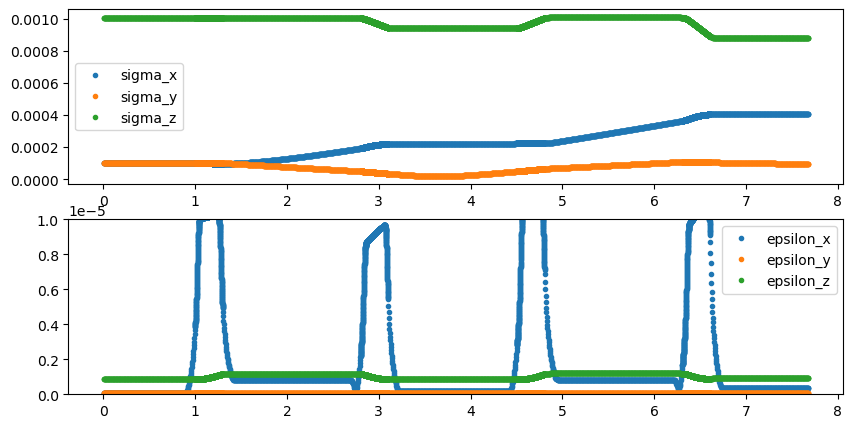

In [4]:
csr_off_h5 = h5py.File('OPAL/lattice_1e4par_100nc_csroff.h5', 'r')
csr_off_stats = get_stats(csr_off_h5)
fig, ax = plot_stats(csr_off_stats)
ax[0].legend()
ax[1].legend()
ax[1].set_ylim(0, 1e-5)
plt.show()
csr_off = last_step(csr_off_h5)
csr_off_par = opal_step_to_bmadx_particle(csr_off)

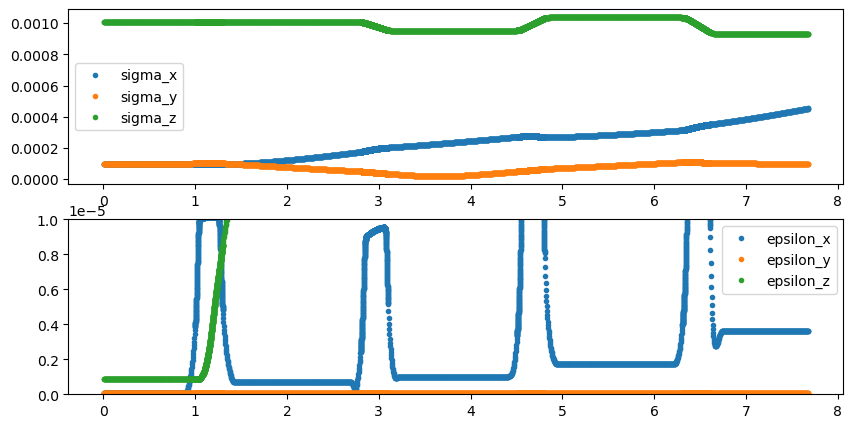

In [5]:
csr_1nc_h5 = h5py.File('OPAL/lattice_1e4par_1nc_csron.h5', 'r')
csr_1nc_stats = get_stats(csr_1nc_h5)
fig, ax = plot_stats(csr_1nc_stats)
ax[0].legend()
ax[1].legend()
ax[1].set_ylim(0, 1e-5)
plt.show()
csr_1nc = last_step(csr_1nc_h5)
csr_1nc_par = opal_step_to_bmadx_particle(csr_1nc)

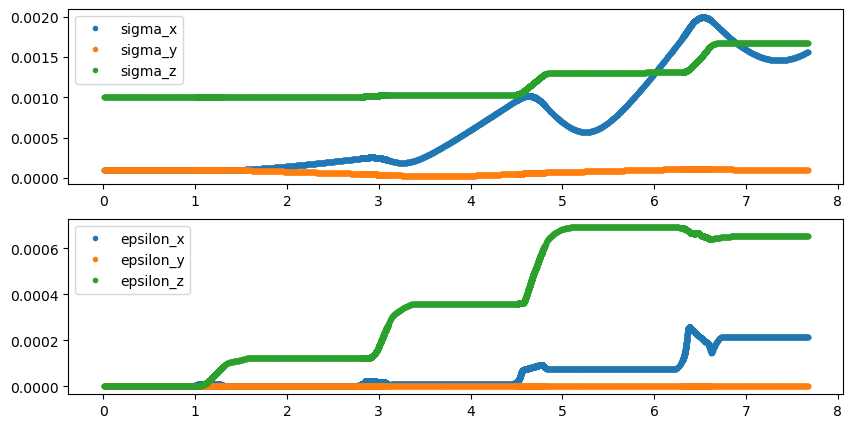

In [6]:
csr_10nc_h5 = h5py.File('OPAL/lattice_1e4par_10nc_csron.h5', 'r')
csr_10nc_stats = get_stats(csr_10nc_h5)
fig, ax = plot_stats(csr_10nc_stats)
ax[0].legend()
ax[1].legend()
#ax[1].set_ylim(0, 1e-6)
plt.show()
csr_10nc = last_step(csr_10nc_h5)
csr_10nc_par = opal_step_to_bmadx_particle(csr_10nc)

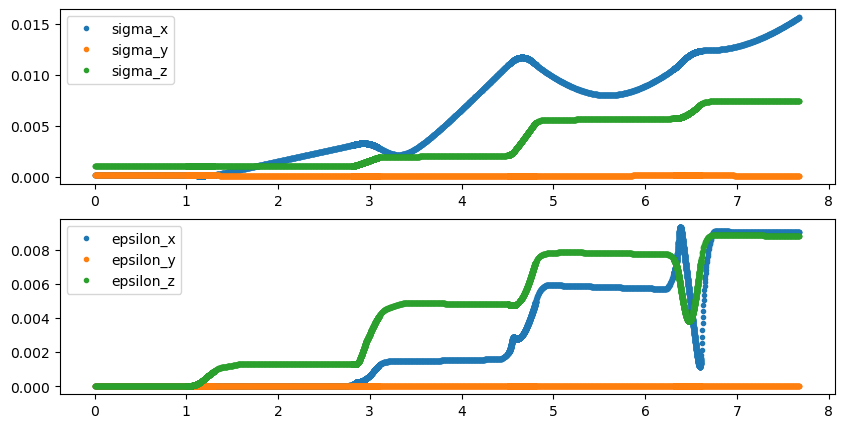

In [7]:
csr_100nc_h5 = h5py.File('OPAL/lattice_1e4par_100nc_csron.h5', 'r')
csr_100nc_stats = get_stats(csr_100nc_h5)
fig, ax = plot_stats(csr_100nc_stats)
ax[0].legend()
ax[1].legend()
#ax[1].set_ylim(0, 1e-6)
plt.show()
csr_100nc = last_step(csr_100nc_h5)
csr_100nc_par = opal_step_to_bmadx_particle(csr_100nc)

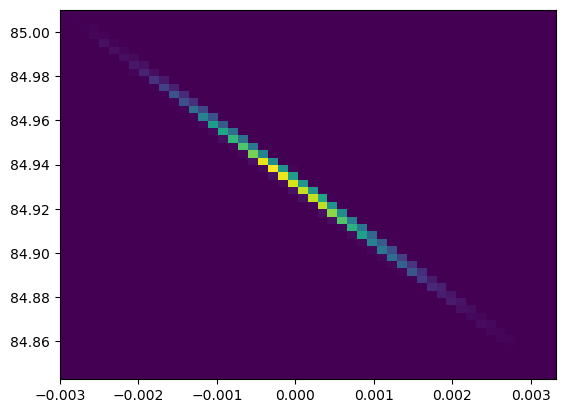

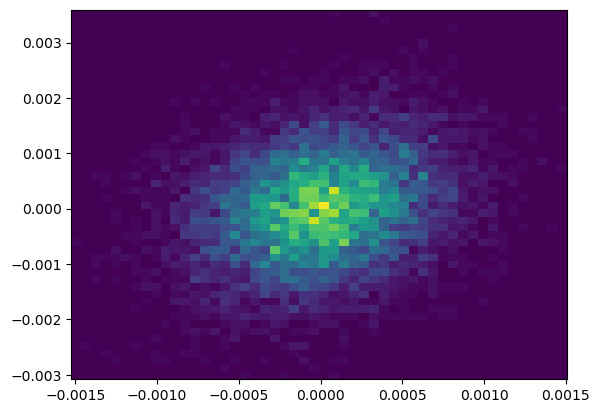

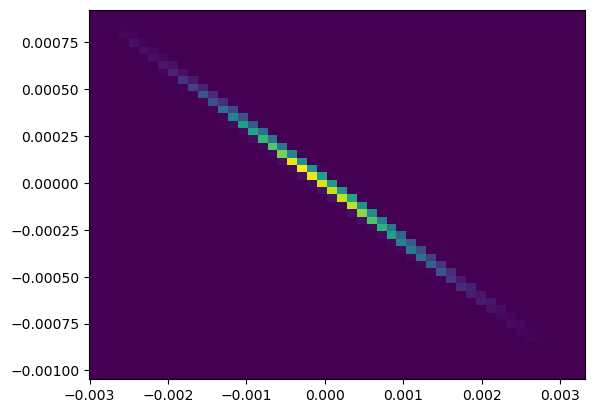

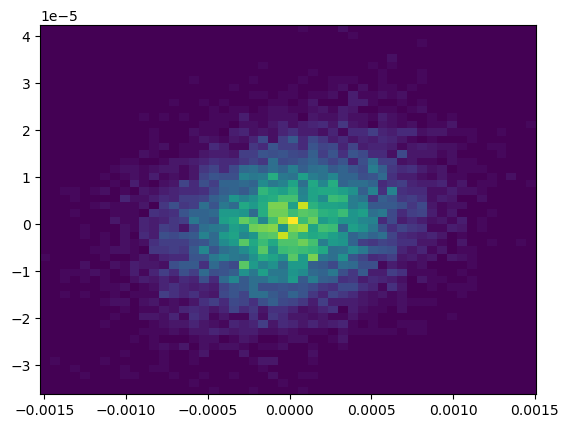

In [51]:
plt.hist2d(csr_off['z'], csr_off['pz'], bins=50)
plt.show()
plt.hist2d(csr_off['x'], csr_off['px'], bins=50)
plt.show()
plt.hist2d(csr_off_par.z, csr_off_par.pz, bins=50)
plt.show()
plt.hist2d(csr_off_par.x, csr_off_par.px, bins=50)
plt.show()

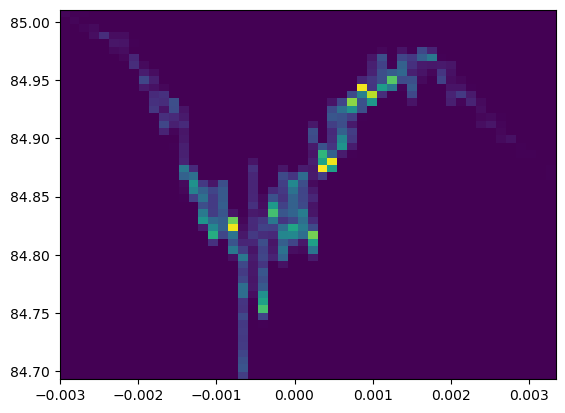

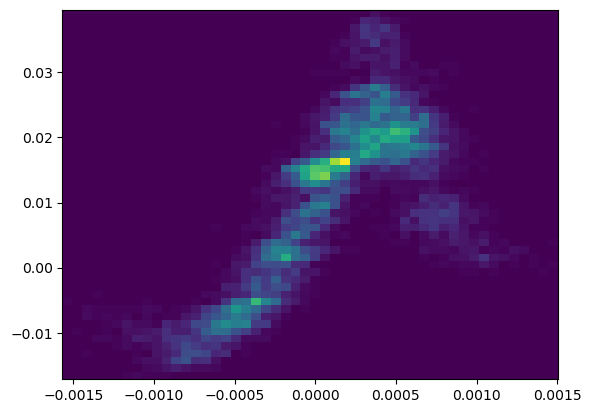

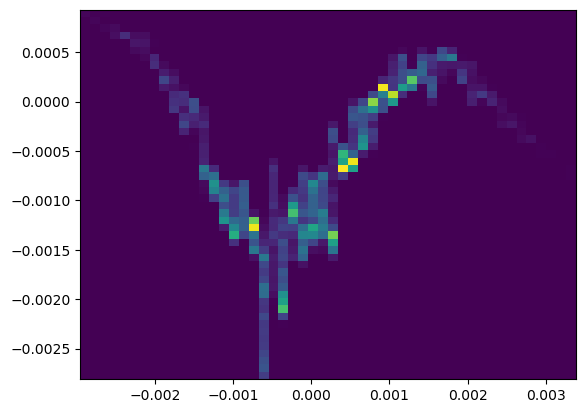

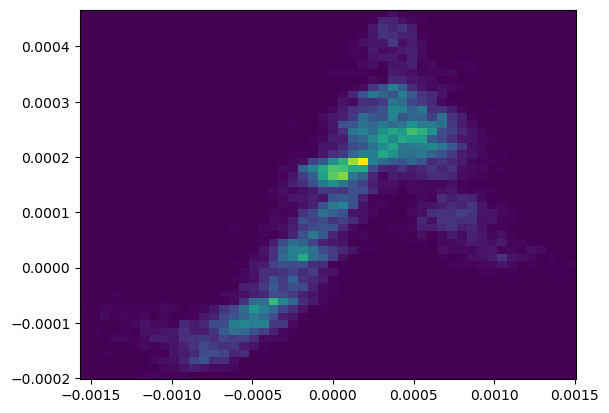

In [52]:
plt.hist2d(csr_1nc['z'], csr_1nc['pz'], bins=50)
plt.show()
plt.hist2d(csr_1nc['x'], csr_1nc['px'], bins=50)
plt.show()
plt.hist2d(csr_1nc_par.z, csr_1nc_par.pz, bins=50)
plt.show()
plt.hist2d(csr_1nc_par.x, csr_1nc_par.px, bins=50)
plt.show()

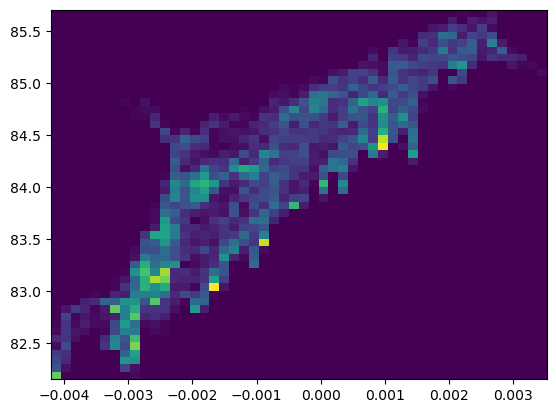

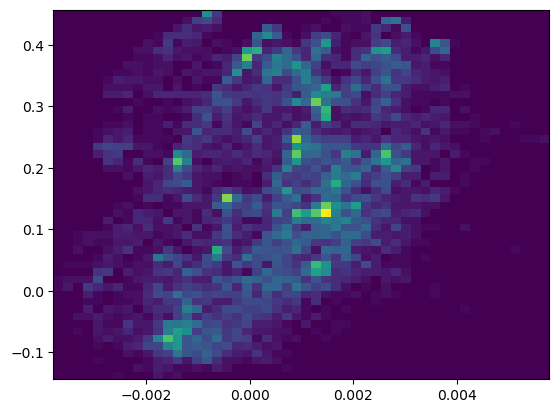

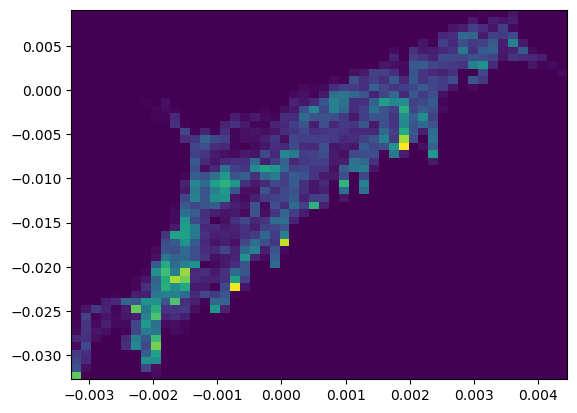

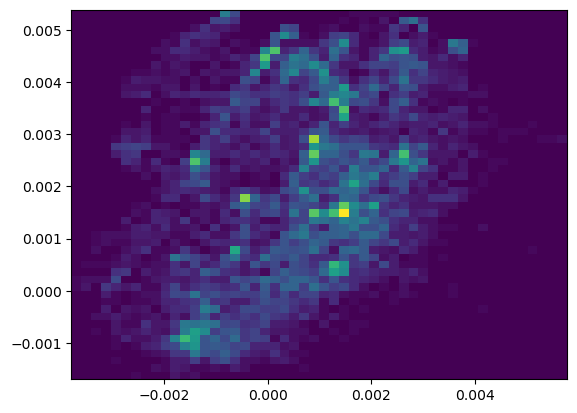

In [53]:
plt.hist2d(csr_10nc['z'], csr_10nc['pz'], bins=50)
plt.show()
plt.hist2d(csr_10nc['x'], csr_10nc['px'], bins=50)
plt.show()
plt.hist2d(csr_10nc_par.z, csr_10nc_par.pz, bins=50)
plt.show()
plt.hist2d(csr_10nc_par.x, csr_10nc_par.px, bins=50)
plt.show()

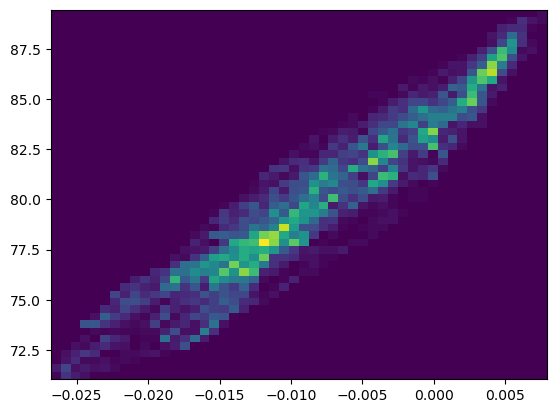

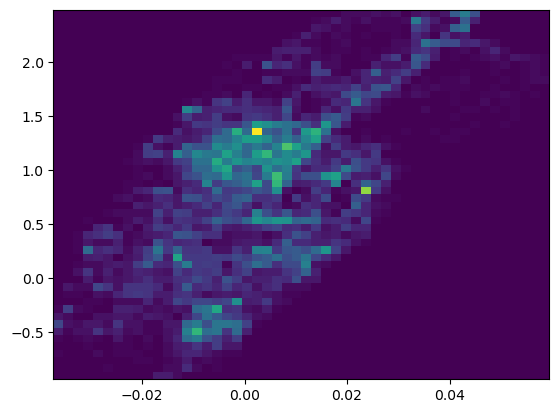

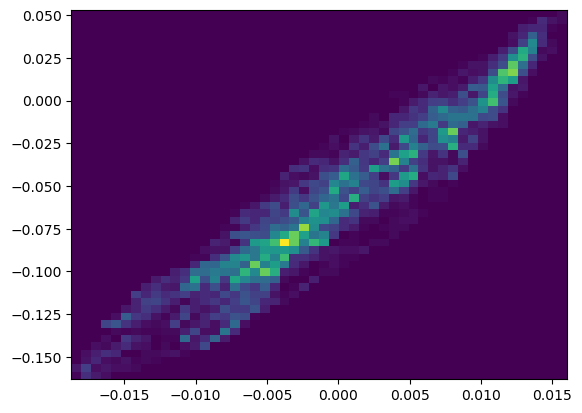

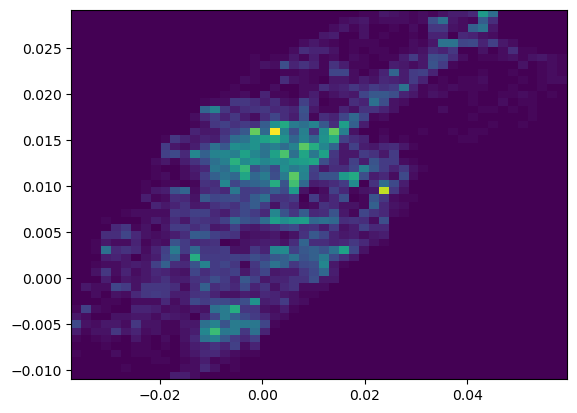

In [54]:
plt.hist2d(csr_100nc['z'], csr_100nc['pz'], bins=50)
plt.show()
plt.hist2d(csr_100nc['x'], csr_100nc['px'], bins=50)
plt.show()
plt.hist2d(csr_100nc_par.z, csr_100nc_par.pz, bins=50)
plt.show()
plt.hist2d(csr_100nc_par.x, csr_100nc_par.px, bins=50)
plt.show()

In [55]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [61]:
def slice_x_px(particle, dim='pz', n_slices=10):
    slice_coord_array = getattr(particle, dim)
    slice_coord_min = slice_coord_array.mean() - 2*slice_coord_array.std()
    slice_coord_max = slice_coord_array.mean() + 2*slice_coord_array.std()
    d_slice = (slice_coord_max - slice_coord_min)/n_slices
    slice_x = [None]*n_slices
    slice_px = [None]*n_slices
    for i in range(n_slices):
        left = slice_coord_min + i*d_slice
        right = left + (i+1)*d_slice
        indices = np.argwhere((slice_coord_array > left) & (slice_coord_array < right))
        slice_x[i] = particle.x[indices[:,0]]
        slice_px[i] = particle.px[indices[:,0]] 
        print(indices.shape)
    return slice_x, slice_px


(299, 1)
(1823, 1)
(4351, 1)
(5182, 1)
(5441, 1)
(4609, 1)
(3643, 1)
(2513, 1)
(1529, 1)
(604, 1)


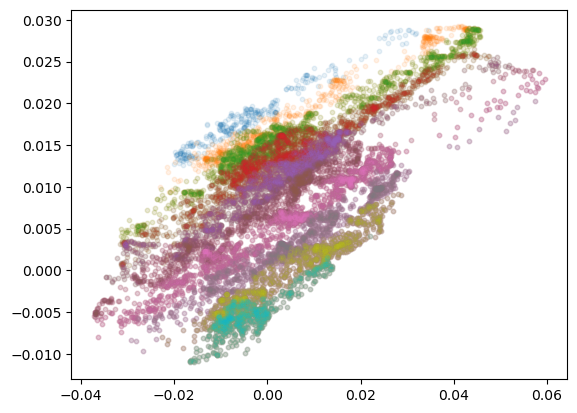

In [62]:
slices_x, slices_px = slice_x_px(csr_100nc_par, dim='z')
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, alpha=0.1)
plt.show()

(241, 1)
(2621, 1)
(4508, 1)
(4570, 1)
(5092, 1)
(4600, 1)
(3541, 1)
(2568, 1)
(1463, 1)
(655, 1)


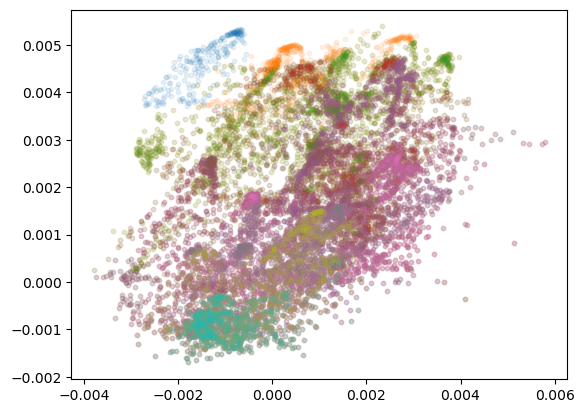

In [63]:
slices_x, slices_px = slice_x_px(csr_10nc_par, dim='z')
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, alpha=0.1)
plt.show()

(293, 1)
(1738, 1)
(3948, 1)
(5630, 1)
(5684, 1)
(4829, 1)
(3440, 1)
(2183, 1)
(1265, 1)
(620, 1)


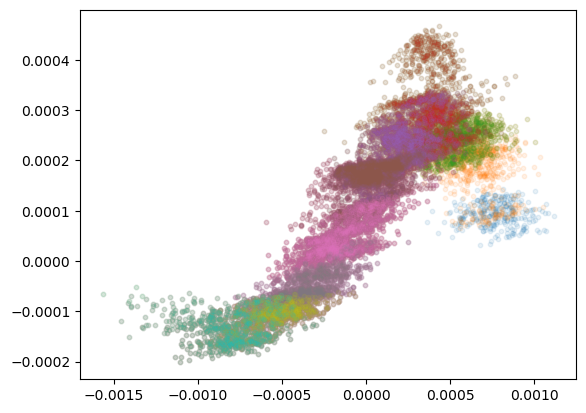

In [64]:
slices_x, slices_px = slice_x_px(csr_1nc_par, dim='z')
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, alpha=0.1)
plt.show()

(327, 1)
(1605, 1)
(3877, 1)
(5748, 1)
(6000, 1)
(4890, 1)
(3438, 1)
(2106, 1)
(1165, 1)
(552, 1)


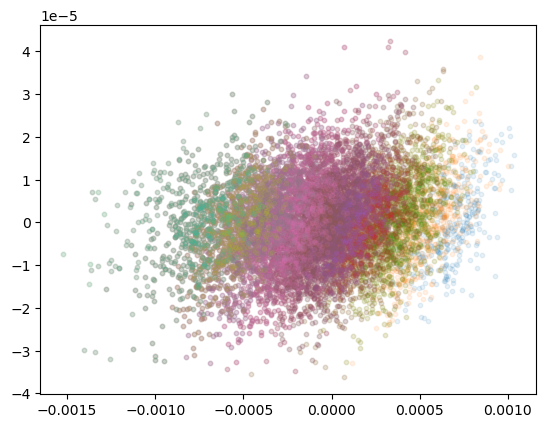

In [65]:
slices_x, slices_px = slice_x_px(csr_off_par, dim='z')
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, alpha=0.1)
plt.show()

In [75]:
def get_cov_ellipse(x, px):
    cov = np.cov(x, px)
    lambda_, v = np.linalg.eig(cov)
    a = 2*np.sqrt(lambda_[0])
    b = 2*np.sqrt(lambda_[1])
    avg_x = np.mean(x)
    avg_px = np.mean(px)
    alpha = np.arctan2(v[1,0], v[0,0])
    rotation = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = np.array([a*np.cos(theta), b*np.sin(theta)])
    ellipse = np.dot(rotation, ellipse)
    ellipse[0] += avg_x
    ellipse[1] += avg_px
    return ellipse

In [76]:
ellipse = get_cov_ellipse(slices_x[0], slices_px[0])

(327, 1)
(1605, 1)
(3877, 1)
(5748, 1)
(6000, 1)
(4890, 1)
(3438, 1)
(2106, 1)
(1165, 1)
(552, 1)


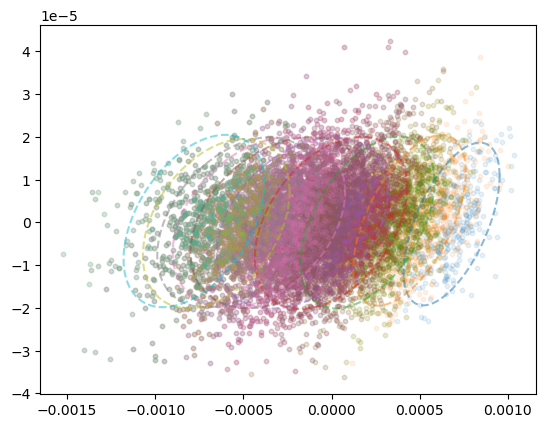

In [85]:
slices_x, slices_px = slice_x_px(csr_off_par, dim='z')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, color=colors[i], alpha=0.1)
    ellipse = get_cov_ellipse(slices_x[i], slices_px[i])
    plt.plot(ellipse[0], ellipse[1], '--',color=colors[i], alpha=0.5)
plt.show()

(293, 1)
(1738, 1)
(3948, 1)
(5630, 1)
(5684, 1)
(4829, 1)
(3440, 1)
(2183, 1)
(1265, 1)
(620, 1)


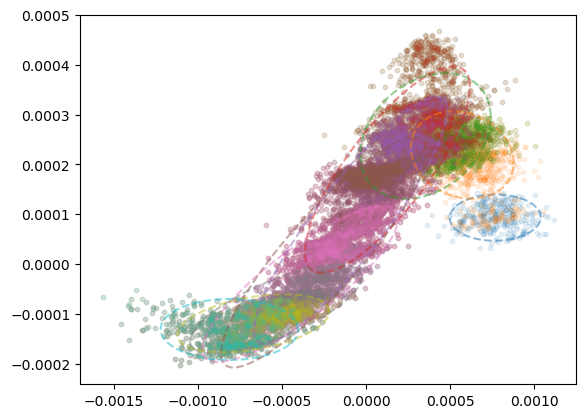

In [86]:
slices_x, slices_px = slice_x_px(csr_1nc_par, dim='z')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, color=colors[i], alpha=0.1)
    ellipse = get_cov_ellipse(slices_x[i], slices_px[i])
    plt.plot(ellipse[0], ellipse[1], '--',color=colors[i], alpha=0.5)
plt.show()

(241, 1)
(2621, 1)
(4508, 1)
(4570, 1)
(5092, 1)
(4600, 1)
(3541, 1)
(2568, 1)
(1463, 1)
(655, 1)


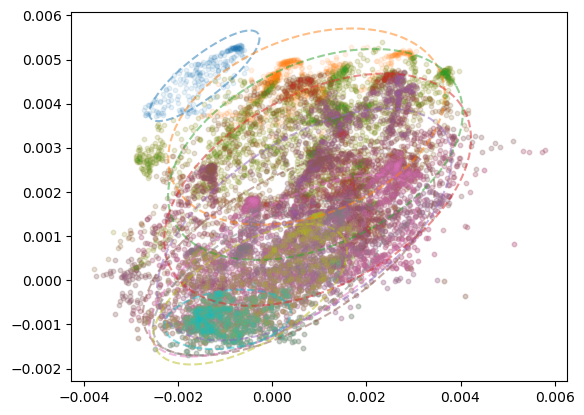

In [87]:
slices_x, slices_px = slice_x_px(csr_10nc_par, dim='z')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, color=colors[i], alpha=0.1)
    ellipse = get_cov_ellipse(slices_x[i], slices_px[i])
    plt.plot(ellipse[0], ellipse[1], '--',color=colors[i], alpha=0.5)
plt.show()

(299, 1)
(1823, 1)
(4351, 1)
(5182, 1)
(5441, 1)
(4609, 1)
(3643, 1)
(2513, 1)
(1529, 1)
(604, 1)


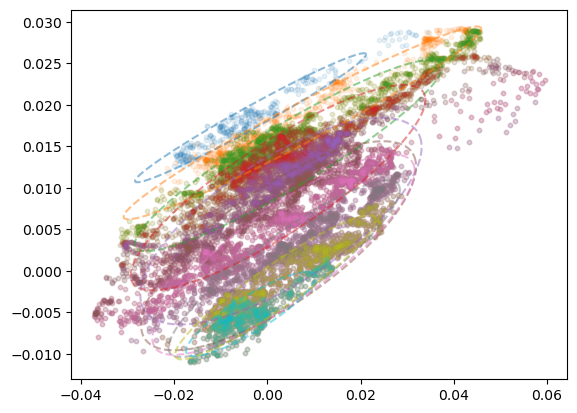

In [88]:
slices_x, slices_px = slice_x_px(csr_100nc_par, dim='z')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(len(slices_x)):
    plt.scatter(slices_x[i], slices_px[i], s=10, color=colors[i], alpha=0.1)
    ellipse = get_cov_ellipse(slices_x[i], slices_px[i])
    plt.plot(ellipse[0], ellipse[1], '--',color=colors[i], alpha=0.5)
plt.show()